# Waveform Processing - First Arrivals
This script shows an example of data loading and estimation of slowness/velocity using First-Arrivals method.
- Section 1. Working Directory and Data Loading
- Section 2. Rearranging and Resampling Data
- Section 3. Data Analysis

## Libraries

In [1]:
import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
import numpy as np                                        # arrays and matrix math
import matplotlib.pyplot as plt                           # plotting

## 1. Working Directory and Data Loading
In this section I load the files I am using:
- JSON
- Receivers location
- Waveform data

A QC to check that the three loaded files are consistent is by comparing the total samples per sample. One value can be calculated based only on JSON parameters, the other can be calculated based on receivers and waveform data.

In [2]:
# Main directory
os.chdir("C:/")
# Data loading
# JSON file
with open('sofi2D.json') as f:
    parameters=json.load(f)
READREC=float(parameters['READREC'])
print('READREC= '+str(READREC))
if READREC==1:
    receivers=np.loadtxt('receiver.dat')        # Receivers location
    N_RECEIVERS=len(receivers)
print('Total Number of Receivers: '+str(N_RECEIVERS))
TIME=float(parameters['TIME'])
DT=float(parameters['DT'])
NDT=float(parameters['NDT'])
print('TIME= '+str(TIME)+' s, DT= '+str(DT)+' s, and NDT= '+str(NDT))
wflength=int((TIME/DT)/NDT)
print('Expected samples per waveform (according to JSON parameters): '+str(wflength))
# Waveforms
data=np.loadtxt('test_p.txt')
SEIS_LENGTH=len(data)/N_RECEIVERS
# Receiver coordinates - if this number is not an integer, then check input files
print('Expected samples per waveform (according to receivers and data files): '+str(SEIS_LENGTH))

READREC= 1.0
Total Number of Receivers: 4
TIME= 0.008 s, DT= 2.5e-08 s, and NDT= 1.0
Expected samples per waveform (according to JSON parameters): 320000
Expected samples per waveform (according to receivers and data files): 320000.0


## 2. Rearranging and Resampling Data
Now I need to prepare the data for analysis. A conventional format is to have one waveform per receiver.
Numerical models (such as SOFI2D) generate data in a single vector, which has to be rearranged into individual waveforms.
Also, numerical models can generate much more data than we need. Reducing waveforms in size can (significantly) improve processing times.

First, I generate a raw waveform array from the data. \
A note on this step is that, for some reason, the last value in the input data seems to be the first value of the first waveform. That is why I build first the first waveform and then the remaining waveforms.
After loading, I normalized the data based on the highest amplitude observed.

In [3]:
# Rearranging
# Extracting waveforms (ASCII format currently)
# The number of receivers is calculated from the receivers file (number of rows)
# Waveform length was calculated before
wfset=np.zeros([N_RECEIVERS,int(SEIS_LENGTH)])
# The last point in the data file is the first point of the first waveform
# First, we compute the first waveform
wfset[0,0]=data[int(len(data))-1]
count=0                                           #count is the position alongs the file
for m in range(1,np.shape(wfset)[1]):
    wfset[0,m]=data[count]
    count=count+1
# Then, we compute the other waveforms
for n in range(1,np.shape(wfset)[0]):
    for m in range(np.shape(wfset)[1]):
        wfset[n,m]=data[count]
        count=count+1
# Amplitude Normalization - Values are normalized to the maximum amplitude observed in the dataset
AmpNorm = wfset.max()
wfset = wfset/AmpNorm

Second, I resample the data to reduce its size.
For practical purposes, it is ideal to have a maximum frequency (step frequency) at least two times that the center frequency.\
Side note here is that TIME=8 ms, while all arrivals are at times lower than 2 ms. However, I am not cutting out this data before the analysis.

After plotting we see that there are three clear arrivals, usually identified as P-wave, S-wave and Stoneley wave.
P-wave amplitude is the lowest.

##### Practice:
Try different values of NewLength and see the effects on resampling.

Raw Time Step: 0.01 us. Raw Frequency Step is: 100000.0 kHz
Time Step: 8.0 us. Raw Frequency Step is: 125.0 kHz


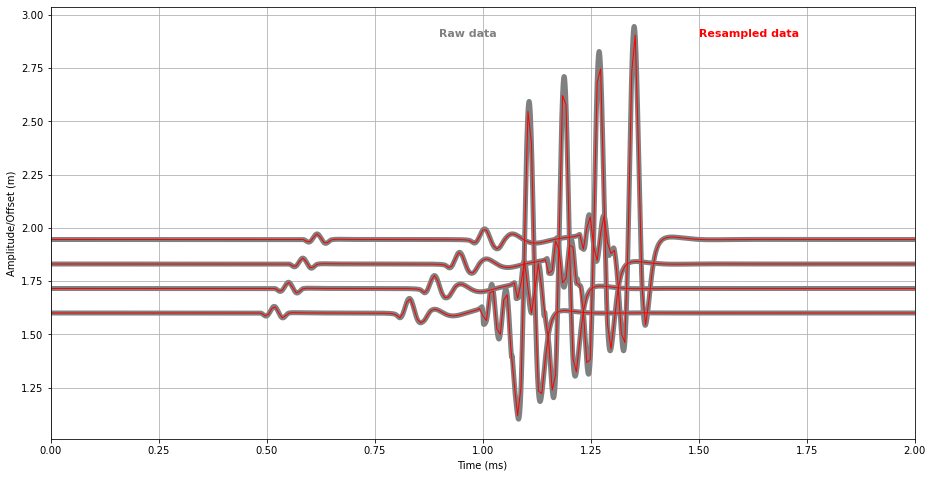

In [4]:
# Resampling
NewLength=1000                                                          # [-] Resampled waveform length

# Index array I use to extract data
Outputindex=np.linspace(0,wflength-1,num=NewLength, dtype=int)

# Time axis building and recomputation
TimeAxis_old=np.linspace(0,TIME,num=wflength)                            # [s]
TimeAxis=TimeAxis_old[Outputindex]                                       # [s]
# Comparison of step before and after resampling
FreqStepOld=1/(1e-8)
FreqStep=1/(TimeAxis[1]-TimeAxis[0])
print('Raw Time Step: '+str(round((1e-8)*1000000, ndigits=2))+' us. Raw Frequency Step is: '+str(round(FreqStepOld/1000,ndigits=2))+' kHz')
print('Time Step: '+str(round((TimeAxis[1]-TimeAxis[0])*1000000, ndigits=2))+' us. Raw Frequency Step is: '+str(round(FreqStep/1000,ndigits=2))+' kHz')

# Plots
fig, ax = plt.subplots()
WF_set=np.zeros([N_RECEIVERS,int(NewLength)])
for n in range(N_RECEIVERS):
    #When plotting, source is at y=0.75 m. That is why we apply the correction to the offset
    ax.plot(TimeAxis_old*1000,receivers[n,1]+wfset[n,:]*1,'gray',linewidth=5)
for n in range(N_RECEIVERS):
    wf=wfset[n,:]
    wfrec=wf[Outputindex]
    WF_set[n,:] = wfrec
    ax.plot(TimeAxis*1000,receivers[n,1]+WF_set[n,:]*1,'red',linewidth=1)
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
ax.text(0.45, 0.95, 'Raw data', transform=ax.transAxes, fontsize=11, verticalalignment='top',color='gray',weight='bold')
ax.text(0.75, 0.95, 'Resampled data', transform=ax.transAxes, fontsize=11, verticalalignment='top',color='red',weight='bold')
ax.set_xlim(0,2)
# ax.set_ylim(1.5,2.2)
plt.xlabel('Time (ms)'); plt.ylabel('Amplitude/Offset (m)')
plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1.5, wspace=0.2, hspace=0.2)

## 3. Data Analysis
### 3.1 Adding noise
Downhole data is noisy... so I add some Gaussian noise to the data. This plot shows that Signal-to-Noise Ratio (SNR) plays a big role when trying to identify the P-wave arrival.\
Amplitude (and SNR) decrease with distance, making signal analysis more difficult.

##### Practice:
Try different values of Noise to analyze its effects during processing.

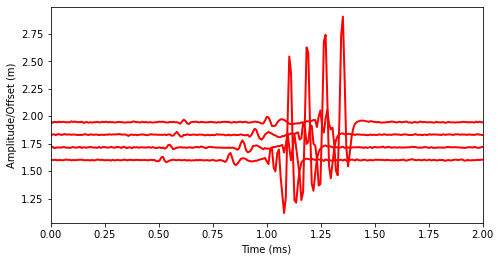

In [10]:
# Background noise
for n in range(N_RECEIVERS):
    wf=wfset[n,:]
    wfrec=wf[Outputindex]
    WF_set[n,:] = wfrec
Noise=0.003

fig, ax = plt.subplots()
for n in range(N_RECEIVERS):
    noise = np.random.normal(loc=0, scale=Noise, size=NewLength)
    WF_set[n,:]=WF_set[n,:]+noise
    ax.plot(TimeAxis*1000,receivers[n,1]+WF_set[n,:]*1,'red',linewidth=2)
ax.set_xlim(0,2)
plt.xlabel('Time (ms)'); plt.ylabel('Amplitude/Offset (m)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1.5, wspace=0.2, hspace=0.2)


### 3.2 Calculating derivative
First derivative analysis can be used to pick the first arrival based on shape change.

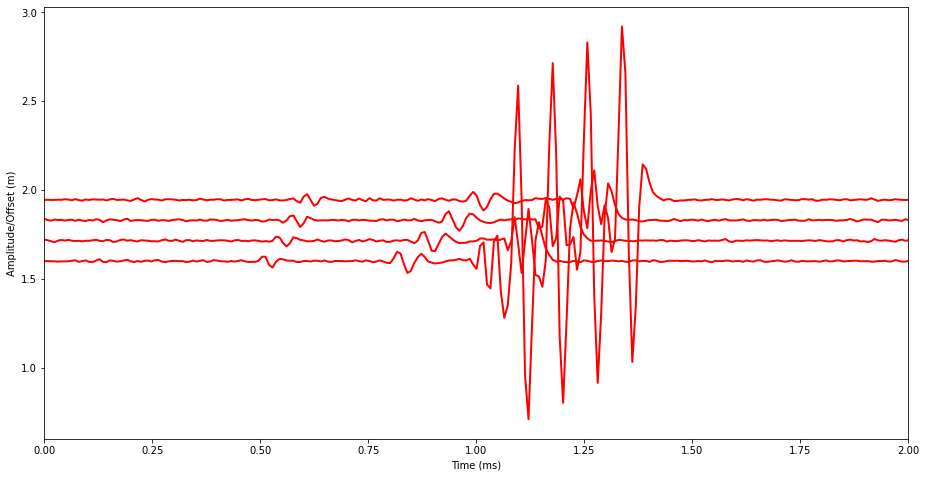

In [6]:
dWF_set=np.gradient(WF_set,TimeAxis,axis=1)
fig, ax = plt.subplots()
for n in range(N_RECEIVERS):
    ax.plot(TimeAxis*1000,receivers[n,1]+dWF_set[n,:]/dWF_set.max(),'red',linewidth=2)
ax.set_xlim(0,2)
plt.xlabel('Time (ms)'); plt.ylabel('Amplitude/Offset (m)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1.5, wspace=0.2, hspace=0.2)

### 3.3 Data Analysis (itself)
First-arrival methods are based on thresholds.\
When amplitudes (or its derivative) crosses a specific threshold, its first threshold-crossing time value is the arrival time.\
For low SNR waveforms, noise can be higher than the first arrival amplitude (or first derivative), increasing the risk of cycle skipping.

##### Practice:
Try different values of threshold to avoid (or not cycle-skipping).\
Some extra work: Can you define thresholds to obtain S-wave and Stoneley velocities?

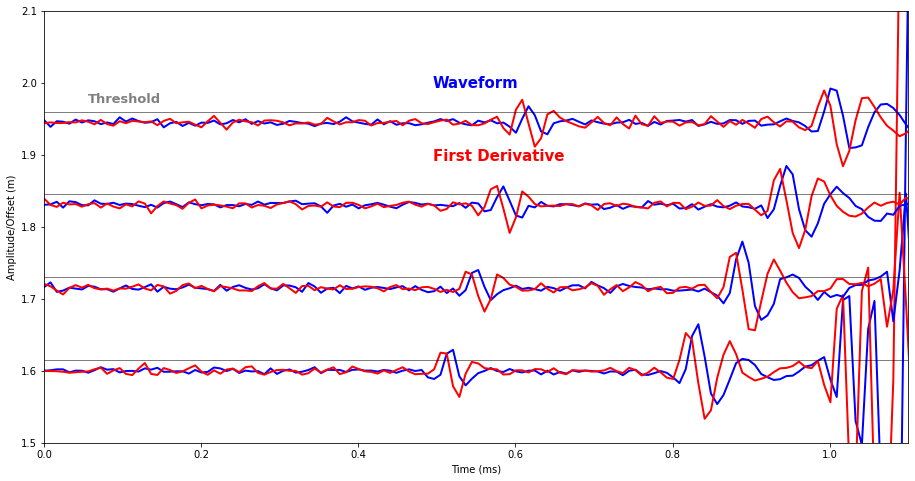

In [12]:
# First-arrival threshold
threshold=0.015

fig, ax = plt.subplots()
for n in range(N_RECEIVERS):
    ax.plot(TimeAxis*1000,receivers[n,1]+WF_set[n,:],'blue',linewidth=2)
    ax.plot(TimeAxis*1000,receivers[n,1]+dWF_set[n,:]/dWF_set.max(),'red',linewidth=2)
    ax.plot([0,2],[receivers[n,1]+threshold,receivers[n,1]+threshold],'black',linewidth=0.5)
ax.set_xlim(0,1.1)
ax.set_ylim(1.5,2.1)
plt.xlabel('Time (ms)'); plt.ylabel('Amplitude/Offset (m)')
ax.text(0.45, 0.85, 'Waveform', transform=ax.transAxes, fontsize=15, verticalalignment='top',color='blue',weight='bold')
ax.text(0.45, 0.68, 'First Derivative', transform=ax.transAxes, fontsize=15, verticalalignment='top',color='red',weight='bold')
ax.text(0.05, 0.81, 'Threshold', transform=ax.transAxes, fontsize=13, verticalalignment='top',color='grey',weight='bold')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1.5, wspace=0.2, hspace=0.2)

... let's see the first picks...

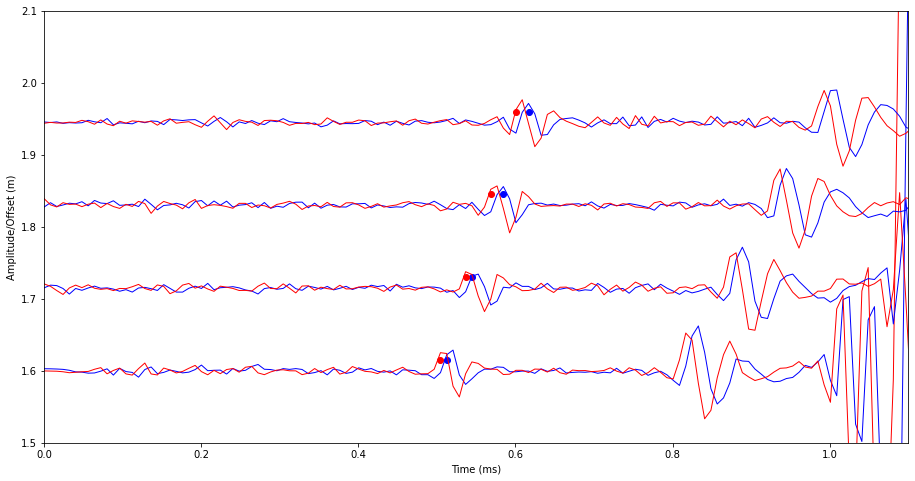

In [8]:
first_arr=np.zeros(N_RECEIVERS)
first_arr_der=np.zeros(N_RECEIVERS)
fig, ax = plt.subplots()
for n in range(N_RECEIVERS):
    first_arrsample = np.where((WF_set[n,:] >= threshold))   #look the sample index for that specific window start time
    first_arr[n] = TimeAxis[first_arrsample[0][0]]*1000
    first_arrsample = np.where((dWF_set[n,:]/dWF_set.max() >= threshold))   #look the sample index for that specific window start time
    first_arr_der[n] = TimeAxis[first_arrsample[0][0]]*1000
    ax.plot(TimeAxis*1000,receivers[n,1]+WF_set[n,:],'blue',linewidth=1)
    ax.plot(TimeAxis*1000,receivers[n,1]+dWF_set[n,:]/dWF_set.max(),'red',linewidth=1)
    ax.scatter(first_arr[n],threshold+receivers[n,1],c='blue')
    ax.scatter(first_arr_der[n],threshold+receivers[n,1],c='red')
ax.set_xlim(0,1.1)
ax.set_ylim(1.5,2.1)
plt.xlabel('Time (ms)'); plt.ylabel('Amplitude/Offset (m)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1.5, wspace=0.2, hspace=0.2)

### 3.4 Calculating velocities (or slownesses)
I calculate formation velocity using all available pairs of first-arrivals, both for the waveform and the first derivative.
Having multiple measurements allows to estimate velocity, measurement uncertainty, and have results despite the presence of outliers (due to cycle-skipping).

##### Practice:
What is P-wave velocity?\

Velocities:
[3590.93335285 3590.93335285 3191.11038848 3590.93335285 3314.11068084
 3590.93335285 2871.40176342 3590.93335285 3191.11038848 3590.93335285
 3590.93335285 3590.93335285]


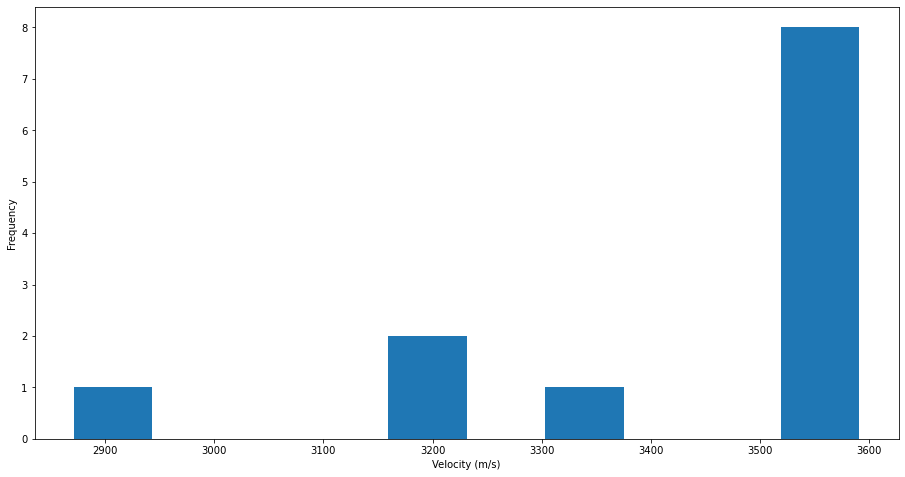

In [9]:
vel=[]
for n in range(N_RECEIVERS):
    for m in range(n+1,N_RECEIVERS):
        dist=(receivers[m,1]-receivers[n,1])
        time=(first_arr[m]-first_arr[n])
        time_der=(first_arr_der[m]-first_arr_der[n])
        vel.append(dist/time*1000)
        vel.append(dist/time_der*1000)
vel=np.array(vel)

print('Velocities:')
print(vel)
fig, ax = plt.subplots()
ax.hist(vel)
plt.xlabel('Velocity (m/s)'); plt.ylabel('Frequency')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1.5, wspace=0.2, hspace=0.2)